# T013 · Data acquisition from PubChem

**Note:** This talktorial is a part of TeachOpenCADD, a platform that aims to teach domain-specific skills and to provide pipeline templates as starting points for research projects.

Authors:

- Jaime Rodríguez-Guerra, 2019-2020, [Volkamer lab, Charité](https://volkamerlab.org/)
- Dominique Sydow, 2019-2020, [Volkamer lab, Charité](https://volkamerlab.org/)
- Yonghui Chen, 2019-2020, [Volkamer lab, Charité](https://volkamerlab.org/)

## Aim of this talktorial

In this notebook, you will learn how to search for compounds similar to an input SMILES in [PubChem](https://pubchem.ncbi.nlm.nih.gov/) with the API web service.

### Contents in *Theory*

- PubChem
- Programmatic access to PubChem

### Contents in *Practical*

* Simple examples for the PubChem API
  * How to get the PubChem CID for a compound
  * Retrieve molecular properties based on a PubChem CID
  * Depict a compound with PubChem
* Query PubChem for similar compounds
  * Determine a query compound
  * Create task and get the job key
  * Download results when job finished
  * Get canonical SMILES for resulting molecules
  * Show the results    

## References

* Literature:
    * PubChem 2019 update: [_Nucleic Acids Res._ (2019), __47__, D1102-1109](https://academic.oup.com/nar/article/47/D1/D1102/5146201)
    * PubChem in 2021: [_Nucleic Acids Res._(2021), __49__, D1388–D1395](https://academic.oup.com/nar/article/49/D1/D1388/5957164)
* Documentation: 
    * [PubChem Source Information](https://pubchem.ncbi.nlm.nih.gov/sources)
    * [PUG REST](https://pubchemdocs.ncbi.nlm.nih.gov/pug-rest)
    * [Programmatic Access](https://pubchemdocs.ncbi.nlm.nih.gov/programmatic-access)
    * [PubChem - Wikipedia](https://en.wikipedia.org/wiki/PubChem)

## Theory

### PubChem

[PubChem](https://pubchem.ncbi.nlm.nih.gov/) is an open database containing chemical molecules and their measured activities against biological assays, maintained by the [National Center for Biotechnology Information (NCBI)](https://www.ncbi.nlm.nih.gov/), part of [National Institutes of Health (NIH)](https://www.nih.gov/). It is the world’s largest freely available database of chemical information, collected from more than 770 data sources. There are three dynamically growing primary subdatabases, i.e., substances, compounds, and bioassay databases. 
As of August 2020, PubChem contains over 110 million unique chemical structures and over 270 million bioactivities ([_Nucleic Acids Res._(2021), __49__, D1388–D1395](https://academic.oup.com/nar/article/49/D1/D1388/5957164)). 

These compounds can be queried using a broad range of properties including chemical structure, name, fragments, chemical formula, molecular weight, XlogP, hydrogen bond donor and acceptor count, etc. There is no doubt that PubChem has become a key chemical information resource for scientists, students, and the general public.

Every data from PubChem is free to access through both the web interface and a programmatic interface. Here, we are going to learn how to use the API of PubChem to do some cool things.

### Programmatic access to PubChem

For some reasons, mainly historical, PubChem provides several ways of programmatic access to the open data.

* [PUG-REST](https://pubchemdocs.ncbi.nlm.nih.gov/pug-rest) is a Representational State Transfer (REST)-style version of the PUG (Power User Gateway) web service, with both the syntax of the HTTP requests and the available functions. It can also provide convenient access to information on PubChem records which are not reachable with other PUG services. 

* PUG-View is another REST-style web service for PubChem. It can provide full reports, including third-party textual annotation, for PubChem records.

*  PUG offers programmatic access to PubChem service via a single common gateway interface (CGI).

* PUG-SOAP uses the simple object access protocol (SOAP) to access PubChem data.

* PubChemRDF REST interface is a special interface for RDF-encoded PubChem data.

For more details about the PubChem API, please check out the introduction of [programmatic access](https://pubchemdocs.ncbi.nlm.nih.gov/programmatic-access) in the PubChem Docs.

In this tutorial, we will focus on the **PUG-REST** variant of the API, please refer to **Talktorial T011** for an introduction.

## Practical

In this section, we will discuss how to search PubChem based on a given query molecule using the PUG-REST access.

In [1]:
import time
from pathlib import Path
from urllib.parse import quote

from IPython.display import Markdown, Image
import requests
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import MolsToGridImage

In [2]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

### Simple examples for the PubChem API
Before querying PubChem for similar compounds, we provide some simple examples to show how to use the PubChem API. For more detail about the PubChem API, see [PUG-REST tutorial](https://pubchemdocs.ncbi.nlm.nih.gov/pug-rest-tutorial).

####  How to get the PubChem CID for a compound
For example, we will search for the PubChem Compound Identification (CID) for Aspirin by name.  

In [3]:
# Get PubChem CID by name
name = "aspirin"

url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{name}/cids/JSON"

r = requests.get(url)
r.raise_for_status()
response = r.json()
if "IdentifierList" in response:
    cid = response["IdentifierList"]["CID"][0]
else:
    raise ValueError(f"Could not find matches for compound: {name}")
print(f"PubChem CID for {name} is:\n{cid}")
# NBVAL_CHECK_OUTPUT

PubChem CID for aspirin is:
2244


#### Retrieve molecular properties based on a PubChem CID
We can get interesting properties for a compound through its PubChem CID, such as molecular weight, pKd, logP, etc. Here, we will search for the molecular weight for Aspirin.

In [4]:
# Get mol weight for aspirin
url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/property/MolecularWeight/JSON"

r = requests.get(url)
r.raise_for_status()
response = r.json()

if "PropertyTable" in response:
    mol_weight = response["PropertyTable"]["Properties"][0]["MolecularWeight"]
else:
    raise ValueError(f"Could not find matches for PubChem CID: {cid}")
print(f"Molecular weight for {name} is:\n{mol_weight}")
# NBVAL_CHECK_OUTPUT

Molecular weight for aspirin is:
180.16


#### Depict a compound with PubChem

The 2D structure of Aspirin:

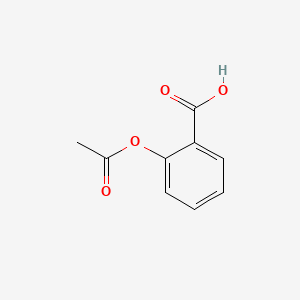

In [5]:
# Get PNG image from PubChem
url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/PNG"

r = requests.get(url)
r.raise_for_status()

display(Markdown("The 2D structure of Aspirin:"))
display(Image(r.content))

### Query PubChem for similar compounds
Use a `SMILES` string of a query compound to search for similar compounds in PubChem.

> Tip: You can check **Talktorial T001** to see how to do a similar operation with the ChEMBL database.

We define a function to query the PubChem service for similar compounds to the given one. The Tanimoto-based similarity between (2D) PubChem fingerprint will be calculated here. You can see [this paper](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-016-0163-1) for more details about similarity evaluation in PubChem, and the [PubChem fingerprint specification](https://ftp.ncbi.nlm.nih.gov/pubchem/specifications/pubchem_fingerprints.pdf) for the details about PubChem fingerprint.

#### 1. Determine a query compound
In the following steps, we will search compounds similar to Gefitinib, an inhibitor for EGFR, from the PubChem service. You can also choose another compound which you are interested in.

The structure of Gefitinib:


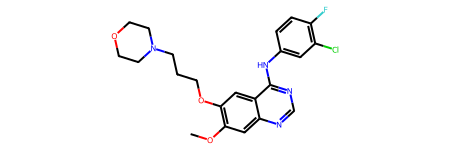

In [6]:
query = "COC1=C(C=C2C(=C1)N=CN=C2NC3=CC(=C(C=C3)F)Cl)OCCCN4CCOCC4"  # Gefitinib
print("The structure of Gefitinib:")
Chem.MolFromSmiles(query)

#### 2. Create task and get the job key

Input the canonical `SMILES` string for the given compound to create a new task, so we obtain a job key here. Note that this asynchronous API will not return the data immediately. In this case, the callback will be provided only when the requested resource is ready, which can be checked by the job key. So asynchronous requests are useful to work around certain slower operations. 

In [7]:
def query_pubchem_for_similar_compounds(smiles, threshold=75, n_records=10):
    """
    Query PubChem for similar compounds and return the job key.

    Parameters
    ----------
    smiles : str
        The canonical SMILES string for the given compound.
    threshold : int
        The threshold of similarity, default 75%. In PubChem, the default threshold is 90%.
    n_records : int
        The maximum number of feedback records.

    Returns
    -------
    str
        The job key from the PubChem web service.
    """
    escaped_smiles = quote(smiles).replace("/", ".")
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/similarity/smiles/{escaped_smiles}/JSON?Threshold={threshold}&MaxRecords={n_records}"
    r = requests.get(url)
    r.raise_for_status()
    key = r.json()["Waiting"]["ListKey"]
    return key

In [8]:
job_key = query_pubchem_for_similar_compounds(query)

#### 3. Download results when job finished
Check if the job finished within the time limit. The standard time limit in PubChem is 30 seconds (we can reset it). It means that if a request is not completed within the time limit, a timeout error will be returned. So, just wait patiently for the callback.

Then download results -  PubChem CIDs in this case -  when the job is finished.

In [9]:
def check_and_download(key, attempts=30):
    """
    Check job status and download PubChem CIDs when the job finished

    Parameters
    ----------
    key : str
        The job key of the PubChem service.
    attempts : int
        The time waiting for the feedback from the PubChem service.

    Returns
    -------
    list
        The PubChem CIDs of similar compounds.
    """
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/listkey/{key}/cids/JSON"
    print(f"Querying for job {key} at URL {url}...", end="")
    while attempts:
        r = requests.get(url)
        r.raise_for_status()
        response = r.json()
        if "IdentifierList" in response:
            cids = response["IdentifierList"]["CID"]
            break
        attempts -= 1
        print(".", end="")
        time.sleep(10)
    else:
        raise ValueError(f"Could not find matches for job key: {key}")
    return cids

In [10]:
similar_cids = check_and_download(job_key)

Querying for job 624510668210559704 at URL https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/listkey/624510668210559704/cids/JSON...

#### 4. Get canonical SMILES for resulting molecules

In [11]:
def smiles_from_pubchem_cids(cids):
    """
    Get the canonical SMILES string from the PubChem CIDs.

    Parameters
    ----------
    cids : list
        A list of PubChem CIDs.

    Returns
    -------
    list
        The canonical SMILES strings of the PubChem CIDs.
    """
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{','.join(map(str, cids))}/property/CanonicalSMILES/JSON"
    r = requests.get(url)
    r.raise_for_status()
    return [item["CanonicalSMILES"] for item in r.json()["PropertyTable"]["Properties"]]

In [12]:
similar_smiles = smiles_from_pubchem_cids(similar_cids)

Then, we create the RDKit molecules and depict them.

In [13]:
query_results_df = pd.DataFrame({"smiles": similar_smiles, "CIDs": similar_cids})
PandasTools.AddMoleculeColumnToFrame(query_results_df, smilesCol="smiles")
query_results_df.head(5)

,smiles,CIDs,ROMol
0,CN1CCC(CC1)COC2=C(C=C3C(=C2)N=CN=C3NC4=C(C=C(C...,3081361,<rdkit.Chem.rdchem.Mol object at 0x7f964f7dbe20>
1,CS(=O)(=O)CCNCC1=CC=C(O1)C2=CC3=C(C=C2)N=CN=C3...,208908,<rdkit.Chem.rdchem.Mol object at 0x7f964f7dbdc0>
2,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,176870,<rdkit.Chem.rdchem.Mol object at 0x7f964f7dbe80>
3,COC1=C(C=C2C(=C1)C(=NC(=N2)N3CCN(CC3)C(=O)C4=C...,68546,<rdkit.Chem.rdchem.Mol object at 0x7f964f7dbee0>
4,CN(CCCNC(=O)C1CCCO1)C2=NC3=CC(=C(C=C3C(=N2)N)O...,2092,<rdkit.Chem.rdchem.Mol object at 0x7f964f7dbf40>


#### 5. Show the results
Show the compounds with images using RDKit's drawing functions.

In [14]:
def multi_preview_smiles(query_smiles, query_name, similar_molecules_pd):
    """
    Show query and similar compounds in 2D structure representation.

    Parameters
    ----------
    query_smiles : str
        The SMILES string of query compound.
    query_name : str
        The name of query compound.
    similar_molecules_pd : pandas
        The pandas DataFrame which contains the SMILES string and CIDs of similar molecules.

    Returns
    -------
    MolsToGridImage
    """

    legends = [f"PubChem CID: {str(s)}" for s in similar_molecules_pd["CIDs"].tolist()]
    molecules = [Chem.MolFromSmiles(s) for s in similar_molecules_pd["smiles"]]
    query_smiles = Chem.MolFromSmiles(query_smiles)
    return MolsToGridImage(
        [query_smiles] + molecules,
        molsPerRow=3,
        subImgSize=(300, 300),
        maxMols=len(molecules),
        legends=([query_name] + legends),
        useSVG=True,
    )

The results of querying similar compounds for Gefitinib:


/home/michael/.miniconda3/envs/teachopencadd/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 10. Change the maxMols value to display more.
  warnings.warn(


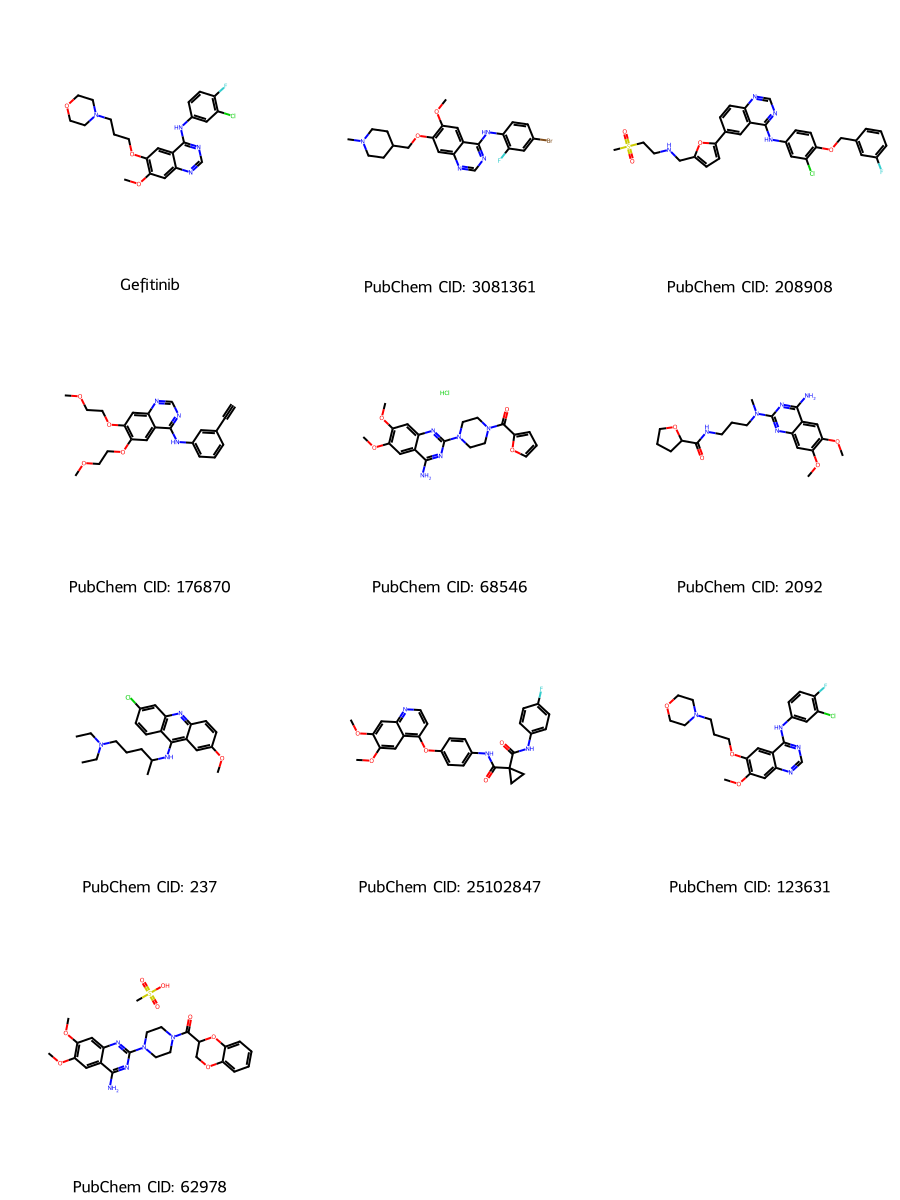

In [15]:
print("The results of querying similar compounds for Gefitinib:")
img = multi_preview_smiles(query, "Gefitinib", query_results_df)
img

## Discussion

In this notebook, you have learned how to access and search similar compounds from the PubChem database via the PUG-REST programmatic access. Is it convenient? PUG-REST can do more than that. See [PUG-REST](https://pubchemdocs.ncbi.nlm.nih.gov/pug-rest-tutorial) to get more power! 


## Quiz

- Can you make the similarity search more strict?
- Is any of the proposed candidates already an approved inhibitor? (Hint: You can _scrape_ [PKIDB](https://www.icoa.fr/pkidb/index.html) and check against the list of SMILES, also see **Talktorial T011**)
- Can you try to reuse the functions in this notebook so search for similar compounds to Imatinib and inspect your results?